In [1]:
import os
import gc
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
from torch.utils.data import DataLoader,Dataset
from IPython import display
from torchvision import transforms
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
path='Chinese Medicine'
f=os.listdir(path)
x=[]
y=[]
for i,t in enumerate(f):
    fp=os.path.join(path,t)
    for j in os.listdir(fp):
        image=Image.open(os.path.join(fp,j))
        image=image.resize((224,224))
        if image.mode != 'RGB':
            image = image.convert('RGB')
        x.append(np.array(image, dtype=np.uint8))
        y.append(i)

In [3]:
class CustomDataset(Dataset):
    def __init__(self, x, y, training=False, transform=None):
        self.x = []          # 图像数据（numpy数组列表）
        self.y = y          # 标签列表
        self.transform = transform
        base_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        for i, img_array in enumerate(x):
            # 应用基础变换并存储
            img_tensor = base_transform(img_array)
            self.x.append(img_tensor)

        self.train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),      # 概率水平翻转
            transforms.RandomVerticalFlip(p=0.3),        # 概率垂直翻转
            transforms.RandomRotation(degrees=15),        # 随机旋转
        ])
        self.is_training = training

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        image = self.x[idx]
        label = self.y[idx]
        if self.is_training and self.transform:
            image = self.transform(image)
        elif self.is_training:
            image = self.train_transform(image)
        return image, label

# 划分训练集和验证集（比例：80%训练，20%验证）
x_train, x_val, y_train, y_val = tts(x, y, test_size=0.2, stratify=y)

# 创建数据集和数据加载器
train_ds = CustomDataset(x_train, y_train, training=True)
test_ds = CustomDataset(x_val, y_val)

batch_size=32
train_iter = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True, pin_memory_device=device)
test_iter = DataLoader(test_ds, batch_size=batch_size, shuffle=False, pin_memory=True, pin_memory_device=device)

for images, labels in train_iter:
    print("训练批次图像形状:", images.shape)
    print("标签形状:", labels.shape)
    break

训练批次图像形状: torch.Size([32, 3, 224, 224])
标签形状: torch.Size([32])


In [4]:
from collections import Counter
Counter(y_val)

Counter({8: 51,
         17: 51,
         10: 50,
         3: 50,
         15: 50,
         7: 50,
         12: 50,
         11: 50,
         0: 50,
         4: 50,
         6: 49,
         16: 49,
         1: 50,
         14: 50,
         5: 50,
         13: 50,
         9: 50,
         2: 49})

In [5]:
Counter(y_train)

Counter({11: 199,
         4: 200,
         2: 199,
         6: 199,
         1: 200,
         5: 200,
         17: 203,
         0: 200,
         8: 202,
         16: 199,
         10: 199,
         14: 199,
         3: 200,
         13: 199,
         12: 199,
         15: 199,
         9: 198,
         7: 199})

In [6]:
def calculate_accuracy(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    # 获取预测类别（取概率最高的类别）
    _, predicted = torch.max(y_pred, 1)
    # 计算正确预测的数量
    correct = (predicted == y_true).float().sum()
    # 计算准确率
    accuracy = correct / y_true.shape[0]
    return accuracy.item() * 100

In [7]:
def train(net:nn.Module, lr=1e-3, epochs=300, device='cuda', is_half=True, early_stop=True, patience=10):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # 交叉熵损失
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=1e-3, betas=(0.99, 0.9999))  # 带L2正则化的Adam
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=1, eta_min=1e-4)
    scaler = torch.amp.GradScaler(device=device)
    train_loss_list=[]
    test_loss_list=[]
    if early_stop:
        patien = patience

    plt.ion()
    for epoch in range(epochs):
        net.train()
        train_loss = 0
        train_acc=0
        for i, j in train_iter:
            i,j=i.to(device),j.to(device)
            optimizer.zero_grad()
            if is_half:
                with torch.amp.autocast(device_type=device):
                    p = net(i)
                    loss = criterion(p, j)
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=100.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                p=net(i)
                loss=criterion(p,j)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=100.0)
                optimizer.step()
            
            train_loss += loss.item()
            train_acc += calculate_accuracy(p,j)
            
        scheduler.step()
        train_loss /= len(train_iter)
        train_acc /= len(train_iter)

        net.eval()
        with torch.no_grad():
            test_loss=0
            test_acc=0
            for i,j in test_iter:
                i,j=i.to(device),j.to(device)
                if is_half:
                    with torch.amp.autocast(device_type=device):
                        p = net(i)
                else:
                    p=net(i)
                test_loss += criterion(p, j).item()
                test_acc += calculate_accuracy(p, j)
            test_loss /= len(test_iter)
            test_acc/=len(test_iter)

        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        #if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], train loss: {train_loss:.5f}, train acc: {train_acc:.3f} test loss: {test_loss:5f}, test acc: {test_acc:.3f}')
        plt.figure(figsize=(8,6))
        plt.clf()
        plt.ylim(0,3)
        plt.xlim(0,epochs)
        plt.plot(range(len(train_loss_list)),train_loss_list,label='train loss')
        plt.plot(range(len(test_loss_list)),test_loss_list,label='test loss')
        plt.legend()
        plt.pause(0.01)
        display.clear_output(wait=True)

        if early_stop:
            if patien == 0:
                break
            elif test_acc+5 < train_acc:
                patien -= 1
            else:
                patien = patience

    plt.ioff()
    plt.plot(range(len(train_loss_list)),train_loss_list,label='train loss')
    plt.plot(range(len(test_loss_list)),test_loss_list,label='test loss')
    plt.legend()
    plt.show()
    print(f'Epoch [{epoch+1}/{epochs}], train loss: {train_loss:.5f}, train acc: {train_acc:.3f} test loss: {test_loss:5f}, test acc: {test_acc:.3f}')
    print("训练完成!")
    return net

In [8]:
def clear():
    gc.collect()
    torch.cuda.empty_cache()
clear()

In [9]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        # 线性层：用 Xavier 均匀分布初始化权重，偏置置零
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv2d):
        # 卷积层：用 Kaiming 正态分布初始化权重，偏置置零
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
torch.backends.cudnn.benchmark = True

In [10]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.01),
            nn.Conv2d(16, 64, kernel_size=3, stride=2, padding=1), 
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(0.2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.25),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
            
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256,64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.15),
            nn.ReLU(),

            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

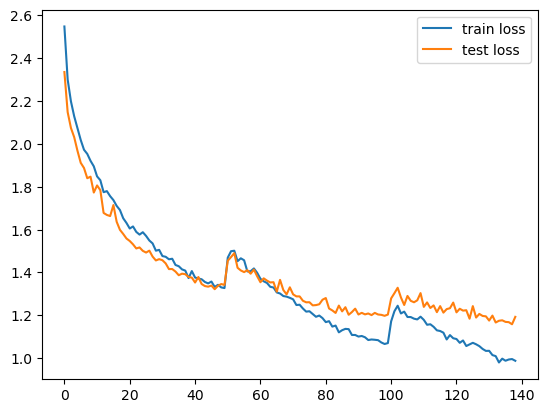

Epoch [139/300], train loss: 0.98835, train acc: 87.368 test loss: 1.193124, test acc: 80.065
训练完成!


In [11]:
clear()
net=CNN(18).to(device)
net.apply(weights_init)
net=train(net)
torch.save(net,'CNN.pth')

In [12]:
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        
        # 增强的特征提取器
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),  # 添加padding保持尺寸
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),  # 调整池化参数
            
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),

            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 128),

            ResidualBlock(128, 256, stride=2),
            ResidualBlock(256, 256),

            ResidualBlock(256, 512, stride=2),
            ResidualBlock(512, 512),
            
            nn.AdaptiveAvgPool2d((1, 1))  # 更稳定的全局池化
        )
        
        # 优化分类器
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),  # 减少神经元数量
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),  # 降低Dropout率

            nn.Linear(256, 64),  # 减少神经元数量
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),  # 降低Dropout率
            
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.01)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
        )
        
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.conv2(out)
        out += identity  # 残差连接
        return nn.LeakyReLU(0.01)(out)

In [13]:
clear()
net=ResNet18(18).to(device)
net.apply(weights_init)
net=train(net)
torch.save(net,'MyResNet18.pth')

KeyboardInterrupt: 

In [19]:
class VisionPatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, in_channels, embed_dim, flatter=True):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, patch_size, patch_size)
        self.norm = nn.LayerNorm(embed_dim)
        self.flatter = flatter

    def forward(self, x):
        x = self.proj(x)
        if self.flatter:
            x = x.flatten(2).transpose(1, 2)  # [B, C, H, W] -> [B, N, C]
        x = self.norm(x)
        return x

class SelfAttention(nn.Module):
    def __init__(self, dim, num_heads, qkv_bias=False, attn_drop_rate=0.0, proj_drop_rate=0.0):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop_rate)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop_rate)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2,0,3,1,4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = torch.matmul(attn, v).transpose(1,2).reshape(B,N,C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, act_layer, drop_rate):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features

        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.drop1 = nn.Dropout(drop_rate)
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop2 = nn.Dropout(drop_rate)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x

class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def drop_path(self, x, drop_prob, training):
        if drop_prob == 0. or not training:
            return x
        keep_prob       = 1 - drop_prob
        shape           = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor   = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_() 
        output          = x.div(keep_prob) * random_tensor
        return output

    def forward(self, x):
        return self.drop_path(x, self.drop_prob, self.training)
    
class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_radio, qkv_bias, drop, attn_drop, drop_path, act_layer, norm_layer):
        super().__init__()
        self.norm_1 = norm_layer(dim)
        self.attn = SelfAttention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop_rate=attn_drop, proj_drop_rate=drop)
        self.norm_2 = norm_layer(dim)
        self.mlp = MLP(in_features=dim, hidden_features=int(dim * mlp_radio), out_features=None, act_layer=act_layer, drop_rate=drop_path)
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity() # 丢弃路径

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm_1(x)))
        x = x + self.drop_path(self.mlp(self.norm_2(x)))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, input_shape, patch_size, in_channels, num_classes, num_features, depth,
                 num_heads, mlp_ratio, qkv_bias, drop_rate, attn_drop_rate, drop_path_rate,
                 norm_layer, act_layer):
        super().__init__()
        self.input_shape = input_shape # 输入的维度
        self.patch_size = patch_size # Patch 的大小
        self.in_channels = in_channels # 输入的维度
        self.num_classes = num_classes # 输出类别数
        self.num_features = num_features # 特征维度
        self.depth = depth # Transformer编码器层数
        self.num_heads = num_heads # Transformer注意力头数
        self.mlp_ratio = mlp_ratio # MLP 比例 MLP:多层感知机,紧随 Self-Attention 之后，用于非线性变换：增强模型的表达能力；特征映射：将 Self-Attention 提取的特征进一步转换。 
        self.qkv_bias = qkv_bias # 是否使用偏置
        self.drop_rate = drop_rate # 丢弃率
        self.attn_drop_rate = attn_drop_rate # 注意力丢弃率
        self.drop_path_rate = drop_path_rate # 丢弃路径率
        self.norm_layer = norm_layer # 归一化层
        self.act_layer = act_layer # 激活函数层

        self.features_shape = [input_shape[0] // patch_size, input_shape[1] // patch_size]  # [14, 14]
        self.num_patches = self.features_shape[0] * self.features_shape[1]
        self.patch_embed = VisionPatchEmbedding(input_shape, patch_size, in_channels, num_features) # 将输入图片分割成patch，并进行线性映射

        # ViT 不是 CNN，没有"感受野"，所以引入了位置编码，来为每个 patch 加上位置信息；
        self.pretrained_features_shape = [224 // patch_size, 224 // patch_size] # 预训练的特征图尺寸

        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_features)) # 分类 token 196, 768 -> 197, 768
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, num_features)) # 位置编码 197, 768 -> 197, 768

        self.pos_drop = nn.Dropout(drop_rate) # 丢弃率
        self.norm = norm_layer(self.num_features) # 归一化

        self.dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)] # 丢弃路径率
        self.blocks = nn.Sequential(
            *[
                Block(
                    dim = num_features,
                    num_heads = num_heads,
                    mlp_radio = mlp_ratio,
                    qkv_bias = qkv_bias,
                    drop = drop_rate,
                    attn_drop = attn_drop_rate,
                    drop_path = self.dpr[i],
                    norm_layer = norm_layer,
                    act_layer = act_layer 
                )for i in range(depth)
            ]
        )
        self.head = nn.Linear(num_features, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self,x):
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1) # 将分类 token 扩展到与输入特征图相同的形状
        x = torch.cat((cls_token, x), dim=1) # 将分类 token 与输入特征图拼接

        cls_token_pos_embed = self.pos_embed[:, 0:1, :] # 分类 token 的位置编码
        img_token_pos_embed = self.pos_embed[:, 1:, :]  # [1, num_patches, num_features]
        # 变成[1, H, W, C]
        img_token_pos_embed = img_token_pos_embed.view(1, self.features_shape[0], self.features_shape[1], -1).permute(0, 3, 1, 2)  # [1, C, H, W]
        # 插值
        img_token_pos_embed = F.interpolate(
            img_token_pos_embed,
            size=self.features_shape,  # [H, W]
            mode='bicubic',
            align_corners=False
        )
        # 变回[1, num_patches, C]
        img_token_pos_embed = img_token_pos_embed.permute(0, 2, 3, 1).reshape(1, -1, img_token_pos_embed.shape[1])

        pos_embed = torch.cat((cls_token_pos_embed, img_token_pos_embed), dim=1) # 将分类 token 的位置编码与图像 token 的位置编码拼接
        
        x = self.pos_drop(x + pos_embed) # 将位置编码与输入特征图相加

        x = self.blocks(x)
        x = self.norm(x)

        return x[:, 0] # 返回分类 token 的特征
    
    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x


In [21]:
clear()
net = VisionTransformer(input_shape=(224, 224),patch_size=16,in_channels=3,num_classes=18
                        ,num_features=512,depth=12,num_heads=8,
                        mlp_ratio=4.0,qkv_bias=True,drop_rate=0.1,
                        attn_drop_rate=0.1,drop_path_rate=0.1,
                        norm_layer=nn.LayerNorm,act_layer=nn.GELU).to(device)
net = train(net)

KeyboardInterrupt: 

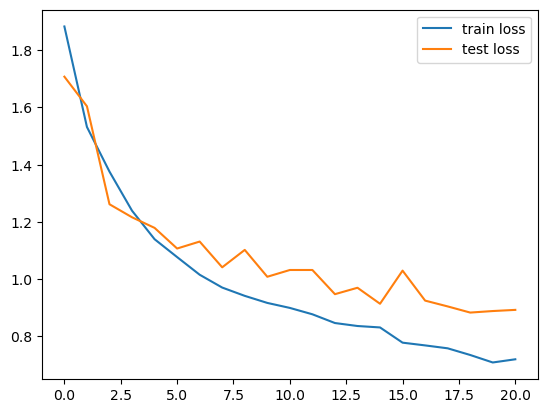

Epoch [21/30], train loss: 0.72023, train acc: 96.294 test loss: 0.892831, test acc: 90.445
训练完成!


In [22]:
from torchvision.models import resnet18
clear()
net=resnet18(pretrained=True)
net.fc = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(net.fc.in_features, 18)
)
net.to(device)
net=train(net, epochs=30, patience=5)
torch.save(net, 'ResNet18.pth')

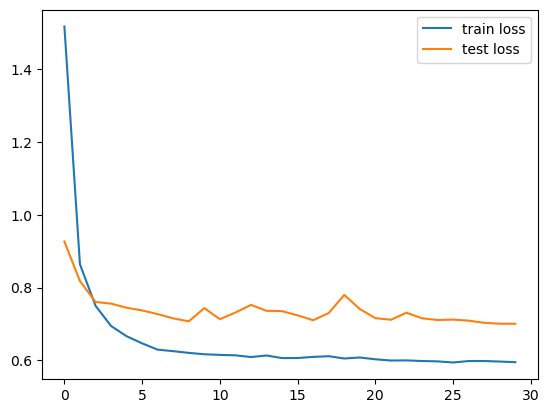

Epoch [30/30], train loss: 0.59534, train acc: 99.723 test loss: 0.700751, test acc: 95.905
训练完成!


In [23]:
from torchvision.models.efficientnet import efficientnet_b4
clear()
net = efficientnet_b4(pretrained=True)
net.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(1792, 18),
)
net.to(device)
net=train(net, epochs=30, patience=5)
torch.save(net, 'efficientnet_b4.pth')

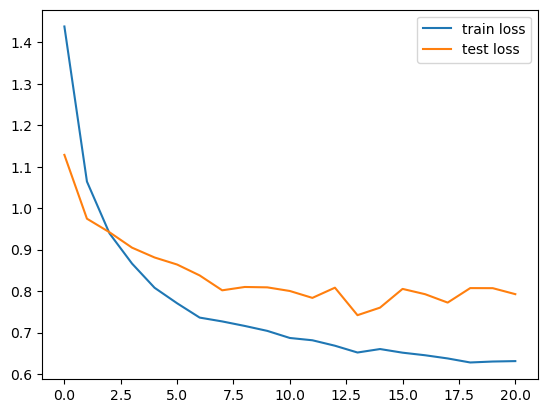

Epoch [21/30], train loss: 0.63133, train acc: 98.795 test loss: 0.792733, test acc: 93.786
训练完成!


In [24]:
from torchvision.models.efficientnet import efficientnet_v2_s
clear()
net=efficientnet_v2_s(pretrained=True)
net.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(1280, 18)
)
net.to(device)
net=train(net, epochs=30, patience=5)
torch.save(net, 'efficientnet_v2_s.pth')

In [25]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_allocated()/1024**3

0.7871685028076172